In [2]:
import numpy as np
import scipy
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt


In [3]:
%load_ext autoreload
%autoreload 2

import ed

# Exercise 7.1: Matrix product state (MPS) basics

a) As in Exercise 6.2, generate the ground state of the transverse field Ising model with open boundary conditions for $L=14, g=1.5, J \equiv 1$. Make sure it is normalized to $\langle\psi \mid \psi\rangle=1$.

In [13]:
L = 14
g = 1.5 
sx_list = ed.gen_sx_list(L)
sz_list = ed.gen_sz_list(L)
H = ed.gen_hamiltonian(sx_list, sz_list, g)
E, GS = sparse.linalg.eigsh(H, k=1, which='SA')
# print(E)
print(f'E = {E[0]:.2f}')

E = -23.22


In [14]:
np.dot(GS.flatten(), GS.flatten())

0.9999999999999973

b) Write a function compress(psi, L, chimax), which takes the state, the length of the chain and the maximal desired bond dimension chimax as input and compresses the state into MPS form using successive SVDs. It should return a list of $L$ numpy arrays, namely the $M^{[n]}$, each with 3 indices $\left(\alpha_n, j_n, \alpha_{n+1}\right)$.
Hint: Let us define the indices $R_n=\left(j_n, j_{n+1}, \ldots, j_L\right)$, such that $R_1 \equiv i$.
First, introduce the dummy index $\alpha_1$ with a reshape of psi into shape $\left(1,2^L\right)$ for the indices $\alpha_1, R_1$ Then you can perform a loop over $n$ which generates one $M^{[n]}$ in each iteration by splitting $\psi_{\alpha_n, R_n}=M_{\alpha_n, \alpha_{n+1}}^{[n] j_n} \psi_{\alpha_{n+1}, R_{n+1}}$. The necessary steps for this iteration are:
- Reshape $\psi_{\alpha_n, R_n}$ into shape $\left(\chi_n \cdot 2, \operatorname{dim}\left(R_{n+1}\right)\right)$. Note that $\operatorname{dim}\left(R_n\right)=2^{L-(n-1)}$. This corresponds to a regrouping of the indices into $L_n \equiv\left(\alpha_n, j_n\right)$ and $R_{n+1}=$ $\left(j_{n+1}, j_{n+2}, \ldots, j_L\right)$.
- Perform an SVD to split $\psi_{L_n, R_n}=\sum_{\alpha_{n+1}} M_{L_n, \alpha_{n+1}} \lambda_{\alpha_{n+1}} \tilde{\psi}_{\alpha_{n+1}, R_{n+1}}$.
- If necessary, truncate to smaller dimension $\chi_{n+1} \leq \chi_{\max }$. With numpy arrays, this can be done as follows:
```
keep = np.argsort(lambda_n)[::-1][:chimax]
M_n = M_n[:, keep]
lambda_ = lambda_n[keep]
psitilde = psitilde[keep, :]
```
- Reshape $M^{[n]}$ into shape $\left(\chi_n, 2, \chi_{n+1}\right)$ to obtain the indices $\left(L_n, \alpha_{n+1}\right) \rightarrow\left(\alpha_n, j_n, \alpha_{n+1}\right)$.
- Re-absorb the $\Lambda_n$ into $\psi_{\alpha_{n+1}, R_{n+1}}=\lambda_{\alpha_{n+1}} \tilde{\psi}_{\alpha_{n+1}, R_{n+1}}$ using psi = lambda[:, np.newaxis] * psitilde[:, :]

The final $\psi_{\alpha_{L+1}, R_{L+1}}$ is just a $1 \times 1$ matrix containing at most a phase (and overall norm of $\psi$, you can simply discard it.

In [15]:

def compress(psi, L, chimax):
    # Initialize the list to store MPS tensors
    MPS = []
    
    # Initial dummy index α_1
    chi_prev = 1
    psi = psi.reshape((chi_prev, 2**L))
    
    for n in range(1, L + 1):
        # Reshape psi into shape (χ_n * 2, dim(R_{n+1}))
        dim_Rn = 2**(L - (n - 1))
        psi = psi.reshape((chi_prev * 2, dim_Rn // 2))
        
        # Perform SVD
        M_n, lambda_n, psitilde = np.linalg.svd(psi, full_matrices=False)
        
        # Truncate if necessary
        if len(lambda_n) > chimax:
            keep = np.argsort(lambda_n)[::-1][:chimax]
            M_n = M_n[:, keep]
            lambda_n = lambda_n[keep]
            psitilde = psitilde[keep, :]
        
        chi_next = len(lambda_n)  # New bond dimension after truncation
        
        # Reshape U to get M^{[n]}
        M_n = M_n.reshape((chi_prev, 2, chi_next))
        MPS.append(M_n)
        
        # Update psi for the next iteration
        psi = lambda_n[:, np.newaxis] * psitilde[:, :]
        
        # Update bond dimension for next iteration
        chi_prev = chi_next
    
    return MPS

c) What is the maximally necessary bond dimension for $L=14$ ? Call compress() for the ground state with $\chi_{\max }$ larger than that to get an exact MPS representation $\left|\psi_{e x}^{M P S}\right\rangle$.

In [16]:
GSmpsEX = compress(GS, L, 10e4)
dims = [max(m.shape) for m in GSmpsEX]

print(dims, max(dims), sum( m.size for m in GSmpsEX))

[2, 4, 8, 16, 32, 64, 128, 128, 64, 32, 16, 8, 4, 2] 128 43688


d) Call compress() again with $\chi_{\max }=10$ to get a compressed MPS $\left|\psi_{\text {compr }}^{M P S}\right\rangle$. Compare the number of floats stored in both MPS.
Hint: The number of elements in a numpy array $M$ are given by M.size.

In [17]:
GSmpsCOMPR = compress(GS, L, 10)
sum( m.size for m in GSmpsCOMPR)


1688

e) Write a function to calculate the overlap between two MPS. Recall from class that there is an inefficient way (first contracting the bra and ket on top and bottom separately and finally contracting over the $j_1, \ldots j_n$ ) and an efficient way (contracting from left to right); implement the efficient one! Check that the overlap $\left\langle\psi_{e x}^{M P S} \mid \psi_{e x}^{M P S}\right\rangle$ is (close to) 1 and calculate the overlap $\left\langle\psi_{e x}^{M P S} \mid \psi_{\text {compr }}^{M P S}\right\rangle$.

In [9]:
def mps_vdot(Alist, Blist):
    """
    Compute the inner product of two tensors in MPS format, with the convention that
    the complex conjugate of the tensor represented by the first argument is used.

    The i-th MPS tensor Alist[i] is expected to have dimensions ( Da[i], n[i], Da[i+1]),
    and similarly Blist[i] must have dimensions                 ( Db[i], n[i], Db[i+1]),
    with `n` the list of logical dimensions and `Da`, `Db` the lists of virtual bond dimensions.
    """
    Atr = np.reshape(np.transpose(Alist[-1], ( 0, 1, 2)), (Alist[-1].shape[0], Alist[-1].shape[1]))
    Btr = np.reshape(np.transpose(Blist[-1], ( 0, 1, 2)), (Blist[-1].shape[0], Blist[-1].shape[1]))
    R = np.tensordot(Btr, np.conj(Atr), axes=([1], [1])) 
    for i in reversed(range(0, len(Alist)-1)):
        R = np.tensordot(np.conj(Alist[i]), R, axes=([2], [1]))
        R = np.tensordot(Blist[i], R, axes=([1, 2], [1, 2]))
    
    return R.flatten()[0]
    

In [8]:
def crandn(size):
    """
    Draw random samples from the standard complex normal (Gaussian) distribution.
    """
    # 1/sqrt(2) is a normalization factor
    return (np.random.normal(size=size) + 1j*np.random.normal(size=size)) / np.sqrt(2)

def mps_to_full_tensor(Alist):
    """
    Construct the full tensor corresponding to the MPS tensors `Alist`.

    The i-th MPS tensor Alist[i] is expected to have dimensions (n[i], D[i], D[i+1]),
    with `n` the list of logical dimensions and `D` the list of virtual bond dimensions.
    """
    # consistency check: dummy singleton dimension
    assert Alist[0].ndim == 3 and Alist[0].shape[0] == 1
    # formally remove dummy singleton dimension
    T = np.reshape(Alist[0], (Alist[0].shape[1], Alist[0].shape[2]))
    # contract virtual bonds
    for i in range(1, len(Alist)):
        T = np.tensordot(T, Alist[i], axes=(-1, 0))
    # consistency check: trailing dummy singleton dimension
    assert T.shape[-1] == 1
    # formally remove trailing singleton dimension
    T = np.reshape(T, T.shape[:-1])
    return T
    

# logical dimensions
n = [2, 5, 1, 4, 3]

# virtual bond dimensions (rather arbitrarily chosen) 
Da = [1, 3, 4, 7, 6, 1]
Db = [1, 4, 9, 8, 5, 1]

# random MPS matrices (the scaling factor keeps the norm of the full tensor in a reasonable range)
np.random.seed(42)
Alist = [0.4 * crandn(( Da[i],n[i], Da[i+1])) for i in range(len(n))]
Blist = [0.4 * crandn(( Db[i],n[i], Db[i+1])) for i in range(len(n))]
S = mps_to_full_tensor(Alist)
T = mps_to_full_tensor(Blist)

# reference value for inner product
inner_ref = np.vdot(np.reshape(S, -1), np.reshape(T, -1))
# compare with implementation based on efficient contraction
inner = mps_vdot(Alist, Blist)
print(inner, inner_ref)


(-0.030541734148275435+0.9524440852442817j) (-0.030541734148275823+0.9524440852442819j)


In [18]:
mps_vdot(GSmpsEX, GSmpsEX)

0.9999999999999994

In [19]:
mps_vdot(GSmpsEX, GSmpsCOMPR)

0.9999999999999891

f) Write the state $|\uparrow \uparrow \cdots \uparrow\rangle$ as an MPS with bond dimension 1 . Calculate the overlap of this state with the ground state (using MPS techniques, i.e. use the function you wrote in $\mathrm{e})$ ).

In [25]:
UP = [ np.array([[1], [0]]).reshape((1, 2, 1)) for i in range(L)]

In [26]:
mps_vdot(GSmpsEX, UP)

0.8146943347914246

# Exercise 7.2: The AKLT model

In this exercise we will consider the construction of a MPS of a non-trivial quantum state. Namely, the ground state of the Affleck-Kennedy-Lieb-Tasaki model introduced in 1987 2. The spin-1 Hamiltonian is given by
$$
\hat{H}=\sum_i \boldsymbol{S}_i \cdot \boldsymbol{S}_{i+1}+\frac{1}{3}\left(\boldsymbol{S}_i \cdot \boldsymbol{S}_{i+1}\right)^2 .
$$

This model has by construction a ground state in which all nearest neighboring spins share a valence bond, i.e. a spin- $\frac{1}{2}$ singlet
$$
\frac{|\uparrow \downarrow\rangle-|\downarrow \uparrow\rangle}{\sqrt{2}} .
$$

This means that each spin-1 can be thought to be broken up in two spin $-\frac{1}{2}$, and each of the spin- $\frac{1}{2}$ forms a singlet with a spin- $-\frac{1}{2}$ on the adjacent site (see also Fig. 1 (d) and (e)).


a) First construct a dimerized spin- $\frac{1}{2}$ chain of singlets, i.e. we consider a product of singlets $\left(\frac{1}{\sqrt{2}}|\uparrow \downarrow\rangle-\frac{1}{\sqrt{2}}|\downarrow \uparrow\rangle\right) \otimes \cdots \otimes\left(\frac{1}{\sqrt{2}}|\uparrow \downarrow\rangle-\frac{1}{\sqrt{2}}|\downarrow \uparrow\rangle\right)$ on neighboring sites. Convince yourself that this state can be written in the MPS framework with $1 \times 2$ matrices on odd sites and $2 \times 1$ matrices on even sites given by
$$
M^{[2 n-1] \uparrow}=\left(\begin{array}{ll}
\frac{1}{\sqrt{2}} & 0
\end{array}\right), \quad M^{[2 n-1] \downarrow}=\left(\begin{array}{ll}
0 & \frac{-1}{\sqrt{2}}
\end{array}\right), \quad M^{[2 n] \uparrow}=\binom{0}{1}, \quad M^{[2 n] \downarrow}=\binom{1}{0} .
$$

In [83]:
# # AKLT = np.array([ [np.array([[2**(-0.5)], [-2**(-0.5)]]).reshape((1, 2, 1)),
# #         2**(-0.5)*np.array([[1], [1]]).reshape((1, 2, 1))] 
# #           for i in range(L//2)])

# AKLT = np.array([ [np.array([[2**(-0.5)], [-2**(-0.5)]]).reshape((1, 2, 1)),
#         2**(-0.5)*np.array([[1], [1]]).reshape((1, 2, 1))] 
#           for i in range(L//2)])

# AKLT = AKLT.reshape((L,AKLT.shape[-3], AKLT.shape[-2], AKLT.shape[-1]))
# AKLT.shape

In [70]:
Mn = np.array([[ 2**(-0.5), 0],  [0, -2**(-0.5)]]).reshape((1, 2, 2))

In [71]:
Mnn = np.array([[ 0, 1],  [ 1, 0]]).T.reshape(( 2, 2, 1))

In [75]:
AKLT = []
for i in range(L//2):
    AKLT.extend( [ Mn, Mnn])

# AKLT = AKLT.reshape((L,AKLT.shape[-3], AKLT.shape[-2], AKLT.shape[-1]))
len(AKLT)

14

b) Use the overlap function between two MPS that you wrote in the previous exercise to check the norm of this singlet MPS, and to compute the spin-correlation function $\left\langle\sigma_i^z \sigma_j^z\right\rangle$. You should observe that this gives always 0 for $|i-j|>1$.

In [76]:
mps_vdot(AKLT, AKLT)

1.0000000000000002

In [77]:
sx = np.array([[0., 1.], [1., 0.]])
sz = np.array([[1., 0.], [0., -1.]])


In [82]:
def get_corr(state, op, i, j):
    stup = state[:]
    # print(stup[j])
    stup[i] = np.transpose(np.tensordot(stup[i], op, axes=([1], [1])), (0, 2, 1))
    # print(stup[j])
    stup[j] = np.transpose(np.tensordot(stup[j], op, axes=([1], [1])), (0, 2, 1))
    # print(stup[j])
    # print(stup[i].shape)
    # stup[i] = np.tensordot( op, stup[i], axes=([0], [1]))
    # stup[i].shape
    return mps_vdot(stup, state)

get_corr(AKLT, sz, 3, 4)

0.0

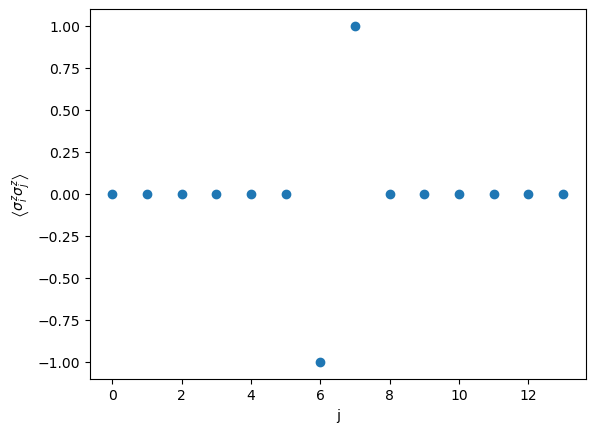

In [85]:
plt.figure()

js = np.arange(0, 14)
coors = []
for j in js:
    coors.append(get_corr(AKLT, sz, L//2, j))

plt.scatter(js, coors)

plt.xlabel('j')
plt.ylabel(r'$\left\langle\sigma_i^z \sigma_j^z\right\rangle$')
# plt.legend()
# plt.yscale('log')

plt.show()

c) Construct the spin-1 projector and apply it to the singlet MPS as shown in Fig. 1 (d) and (e). This gives the MPS representation of the AKLT ground state.